# Figures 2, 3A-B, S1, Table 2

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

from pathlib import Path

from torch_neuron.training import *
from torch_neuron.architectures import *
from torch_neuron.morphology import *
from torch_neuron.dataset import *
from torch_neuron.model_drion import *
from torch_neuron.generate_data import *
from torch_neuron.prep_data import *
from torch_neuron.visualize import *

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

%matplotlib inline

In [2]:
# Selection of seeds for replicability

SEEDS = [20230619, 20230620, 20230621, 20230622, 20230623,
         20230624, 20230625, 20230626, 20230627, 20230628]

In [3]:
# Set date, used for recording results

DATE = 20240617

In [4]:
# Set path for saving images

PATH_images = f'./results/images/20240312/'

In [5]:
# Generate files for voltage and current traces

# GENERATE_TRACES = True
GENERATE_TRACES = False

In [6]:
# Initialize conditions

# Base model parameter settings
center = 1.0 # mean
perturb = 0.3 # standard deviation
lin_nodes_target = 6 # number of compartments
distribution_target = 'manual' # "mode" setting for generating uniform random sampling of parameters
seed = SEEDS[0] # Set one seed for all conditions for replicability

# Smoothing settings
input_noise_sigmas_flags = [[0, False]] # No smoothing, no noise

# Smoothing settings - does not apply for these conditions
kernel_width = 1 # convolution kernel width in time-steps
variance=0.2 # variance of convolution kernel

# Stim and Rec locations
stim_locations_list = [[0],[0,1],[0,-1],[0,1,-1],None]
rec_locations_list = [[0],[0,1],[0,-1],[0,1,-1],None]

# Initialize list of paired stimulation and recording site locations
stim_rec_locations_list = []

for i, stim_loc in enumerate(stim_locations_list):
    for j, rec_loc in enumerate(rec_locations_list):
        stim_rec_locations_list.append([stim_loc, rec_loc])

stim_rec_locations_list = [a for a in stim_rec_locations_list]


# Make conditions dataframe

conditions = {}
count = 0

for stim_rec_locations in stim_rec_locations_list:
        for sigmas_flags in input_noise_sigmas_flags:
        
            conditions[count] = [
                                    stim_rec_locations[0],
                                    stim_rec_locations[1],
                                    sigmas_flags[0],
                                    sigmas_flags[1],
                                    center,
                                    perturb,
                                    lin_nodes_target,
                                    distribution_target,
                                    seed,
                                    
                                 ]

            count += 1
conditions = pd.DataFrame(conditions).transpose()
conditions.columns = ['stim_locations','rec_locations','noise_sigma','flag','mu','sigma','lin_nodes','distribution','seed']

    
conditions

,stim_locations,rec_locations,noise_sigma,flag,mu,sigma,lin_nodes,distribution,seed
0,[0],[0],0,False,1.0,0.3,6,manual,20230619
1,[0],"[0, 1]",0,False,1.0,0.3,6,manual,20230619
2,[0],"[0, -1]",0,False,1.0,0.3,6,manual,20230619
3,[0],"[0, 1, -1]",0,False,1.0,0.3,6,manual,20230619
4,[0],None,0,False,1.0,0.3,6,manual,20230619
5,"[0, 1]",[0],0,False,1.0,0.3,6,manual,20230619
6,"[0, 1]","[0, 1]",0,False,1.0,0.3,6,manual,20230619
7,"[0, 1]","[0, -1]",0,False,1.0,0.3,6,manual,20230619
8,"[0, 1]","[0, 1, -1]",0,False,1.0,0.3,6,manual,20230619
9,"[0, 1]",None,0,False,1.0,0.3,6,manual,20230619


In [7]:
# Initialize data lookup table
data_lookup = conditions.copy()


# Initialize Run Settings
date = DATE # location of saved results in ./results directory
seed = SEEDS[0] # Seed for replication
lr = 0.5 # Learning rate for training
batch_size = 100 # Number of input-output pairs in data
epochs = 200 # Number of training epochs
patience = 5 # Early stopping patience (not used)
epoch_thresh = 0 # epoch early stopping checks begin (not used)
delta = 0.05 # loss change threshold for early stopping (not used

method = 'variablestep' # Input method for variable step current
hazard_rate = 0.05 # Rate at which variable steps change

kernel_width = 1 # convolution kernel width in time-steps (not used)
variance = 0.2 # variance of convolution kernel (not used)
input_noise_mu = 0 # mean noise (not used)
input_noise_seed = seed # noise seed for replicability (not used)

override=True # Flag to force parameters to be a particular value when initializing model
constant=False # Flag to make parameters learnable (False - leanable, True - not learnable i.e. constant)

center = 1.0 # mean parameter settings
perturb = 0.3 # standard deviation parameter settings


# VARIABLE TARGET CONDITIONS - Target parameters are randomly initialized
lin_nodes_target = 6 # number of compartments - toy model
distribution_target = 'manual' # Uniform random initialization
mu_target = center # uniform random initialization
sigma_target = perturb # uniform random initialization


# STABLE MODEL INITIALIZATION - Initial Model parameters are homogeneous
lin_nodes_model = 6 # number of compartments - toy model
distribution_model = 'linear' # homogeneous initialization
mu_model = 1.0 # homogeneous initialization
sigma_model = 0.0 # homogeneous initialization


# Build data lookup file by checking which files exist
for condition_num, condition in conditions.iterrows():

    # Assign identifying condition information
    stim_locations = condition["stim_locations"]
    rec_locations = condition["rec_locations"]
    
    input_noise_sigma = condition["noise_sigma"]
    noise_flag = condition["flag"]
    

    # Set hyperparameters for optimizing model and target model initialization

    # Target model hyperparameter initialization
    hyperparams_target = set_hyperparams_stim(date=date,
                                             seed=seed,
                                             lin_nodes=lin_nodes_target,
                                             distribution=distribution_target,
                                             mu=mu_target,
                                             sigma=sigma_target,
                                             method=method,
                                             seed_target=seed,
                                             hazard_rate=hazard_rate,
                                             kernel_width=kernel_width,
                                             variance=variance,
                                             noise_flag=noise_flag,
                                             input_noise_mu=input_noise_mu,
                                             input_noise_sigma=input_noise_sigma,
                                             input_noise_seed=input_noise_seed,
                                             stim_locations=stim_locations,
                                             rec_locations=rec_locations,
                                             )

    # Optimization model hyperparameter initialization
    hyperparams_model = set_hyperparams_stim(date=date,
                                             seed=seed,
                                             lin_nodes=lin_nodes_model,
                                             distribution=distribution_model,
                                             mu=mu_model,
                                             sigma=sigma_model,
                                             method=method, 
                                             seed_target=seed,
                                             hazard_rate=hazard_rate,
                                             kernel_width=kernel_width,
                                             variance=variance,
                                             noise_flag=noise_flag,
                                             input_noise_mu=input_noise_mu,
                                             input_noise_sigma=input_noise_sigma,
                                             input_noise_seed=input_noise_seed,
                                             stim_locations=stim_locations,
                                             rec_locations=rec_locations,
                                            )

    # Set Manual Distibution and adjust hyperparameters accordingly

    # Optimization model does not have randomly initialized parameters
    manual_dist_model = None 
    # Target model has randomly initialized parameters
    manual_dist_target = init_random_model_params(hyperparams=hyperparams_target, 
                                                  center=mu_target,
                                                  perturb=sigma_target,
                                                  manual_seed=seed
                                                  )
    hyperparams_target['manual_dist'] = manual_dist_target

    # Initialize toy model adjacency matrix
    adj_mat_model = Lin_mat(hyperparams_model['lin_nodes'])


    # Make file path names to check for their existence
    PATH = f'./results/{date}/'
    PATH_target = f'targ_nodes_{lin_nodes_target}_dist_{distribution_target}_mu_{mu_target}_sigma_{sigma_target}/'
    PATH_seed = f'seed_{seed}/'
    PATH_lr = f'lr_{lr}/'
    PATH_complete = PATH+PATH_target+PATH_seed+PATH_lr
    Path(PATH_complete).mkdir(parents=True, exist_ok=True)

    stim_loc = hyperparams_target['stim_locations']
    if stim_loc == None:
            stim_id = 'all'
    else:
        stim_id = '_'.join(map(str, stim_loc))

    rec_loc = hyperparams_target['rec_locations']
    if rec_loc == None:
            rec_id = 'all'
    else:
        rec_id = '_'.join(map(str, rec_loc))

    settings = f'i_min_{hyperparams_model["i_min"]}_i_max_{hyperparams_model["i_max"]}_method_{hyperparams_model["method"]}'
    model_settings = f'dist_{hyperparams_model["distribution"]}_{hyperparams_model["mu"]}_{hyperparams_model["sigma"]}'
    stim_rec = f'stim_{stim_id}_rec_{rec_id}'
    filename_id = f'ax_{hyperparams_model["ax_weight"]}_{settings}_{model_settings}_{stim_rec}'
    
    if hyperparams_target['noise_flag'] == True:
            noise_file_str = f'_noise_sigma_{hyperparams_target["input_noise_sigma"]}_noise_seed_{hyperparams_target["input_noise_seed"]}'
            filename_id = filename_id + noise_file_str
    

    loss_file = f'loss_{filename_id}'
    g_Na_file = f'g_Na_{filename_id}'
    g_K_file = f'g_K_{filename_id}'
        
    row_ix = data_lookup.index[(data_lookup['stim_locations'].apply(lambda x: x == stim_loc)) \
                               & (data_lookup['rec_locations'].apply(lambda x: x == rec_loc)) \
                               & (data_lookup['noise_sigma'].apply(lambda x: x == input_noise_sigma)) \
                               & (data_lookup['flag'].apply(lambda x: x == noise_flag))]

    # Generate filename
    file_to_check_loss = Path(PATH_complete+loss_file)
    file_to_check_g_Na = Path(PATH_complete+g_Na_file)
    file_to_check_g_K = Path(PATH_complete+g_K_file)

    # Check if filename exists for each condition
    file_exists_loss = Path.exists(file_to_check_loss)
    file_exists_g_Na = Path.exists(file_to_check_g_Na)
    file_exists_g_K = Path.exists(file_to_check_g_K)

    if not row_ix.empty:
        data_lookup.loc[row_ix, 'loss_filename_exists'] = file_exists_loss
        data_lookup.loc[row_ix, 'g_Na_filename_exists'] = file_exists_g_Na
        data_lookup.loc[row_ix, 'g_K_filename_exists'] = file_exists_g_K
        data_lookup.loc[row_ix, 'loss_filename_id'] = PATH_complete+loss_file
        data_lookup.loc[row_ix, 'g_Na_filename_id'] = PATH_complete+g_Na_file
        data_lookup.loc[row_ix, 'g_K_filename_id'] = PATH_complete+g_K_file

# Set data lookup table to only include files that exist
data_lookup = data_lookup[data_lookup['loss_filename_exists'] == True].reset_index(drop=True)
data_lookup

Int64Index([0], dtype='int64')
Int64Index([1], dtype='int64')
Int64Index([2], dtype='int64')
Int64Index([3], dtype='int64')
Int64Index([4], dtype='int64')
Int64Index([5], dtype='int64')
Int64Index([6], dtype='int64')
Int64Index([7], dtype='int64')
Int64Index([8], dtype='int64')
Int64Index([9], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([12], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([14], dtype='int64')
Int64Index([15], dtype='int64')
Int64Index([16], dtype='int64')
Int64Index([17], dtype='int64')
Int64Index([18], dtype='int64')
Int64Index([19], dtype='int64')
Int64Index([20], dtype='int64')
Int64Index([21], dtype='int64')
Int64Index([22], dtype='int64')
Int64Index([23], dtype='int64')
Int64Index([24], dtype='int64')


,stim_locations,rec_locations,noise_sigma,flag,mu,sigma,lin_nodes,distribution,seed,loss_filename_exists,g_Na_filename_exists,g_K_filename_exists,loss_filename_id,g_Na_filename_id,g_K_filename_id
0,[0],None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
1,"[0, 1]",None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
2,"[0, -1]",None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
3,"[0, 1, -1]",None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
4,None,[0],0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
5,None,"[0, 1]",0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
6,None,"[0, -1]",0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
7,None,"[0, 1, -1]",0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
8,None,None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...


In [8]:
# Set font sizes
plt.rcParams['font.size'] = 14

## Fig3A, FigS1A-E: Experimental Conditions - Stimulate All, Limit Recording

### Generate Traces

In [42]:
# Select traces for the "Limit Recordings, Stimulate All" semi-ideal data conditions
fig_2_a_selected = data_lookup[data_lookup.apply(lambda row: row['stim_locations'] == None, axis=1)]
fig_2_a_selected

,stim_locations,rec_locations,noise_sigma,flag,mu,sigma,lin_nodes,distribution,seed,loss_filename_exists,g_Na_filename_exists,g_K_filename_exists,loss_filename_id,g_Na_filename_id,g_K_filename_id
4,None,[0],0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
5,None,"[0, 1]",0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
6,None,"[0, -1]",0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
7,None,"[0, 1, -1]",0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
8,None,None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...


In [43]:
# Generate initial, final, and target voltage traces for each data condition
if GENERATE_TRACES == True:
    entry_ixs = fig_2_a_selected.index
    for entry_ix in entry_ixs:
        generate_all_voltage_traces(data_lookup, entry_ix=entry_ix, hyperparams=hyperparams_target)

## Generate Fig3A, FigS1A-E

Int64Index([8, 7, 6, 5, 4], dtype='int64')
Matching Files:
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_init_nodes_6_dist_manual_mu_1.0_sigma_0.0_stim_all_rec_all_noise_0_flag_False.pth
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_final_nodes_6_dist_manual_mu_1.0_sigma_0.0_stim_all_rec_all_noise_0_flag_False.pth
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_target_nodes_6_dist_manual_mu_1.0_sigma_0.3_stim_all_rec_all_noise_0_flag_False.pth
Matching Files:
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/current_trace_nodes_6_dist_manual_mu_1.0_sigma_0.0_stim_all_rec_all_noise_0_flag_False.pth
Matching Files:
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_init_nodes_6_dist_manual_mu_1.0_sigma_0.0_stim_all_rec_0_1_-1_noise_0_flag_False.pth
./results/20240617

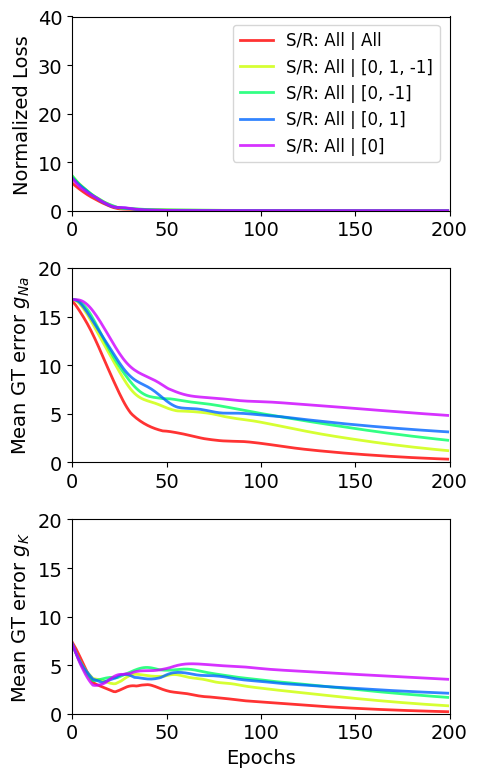

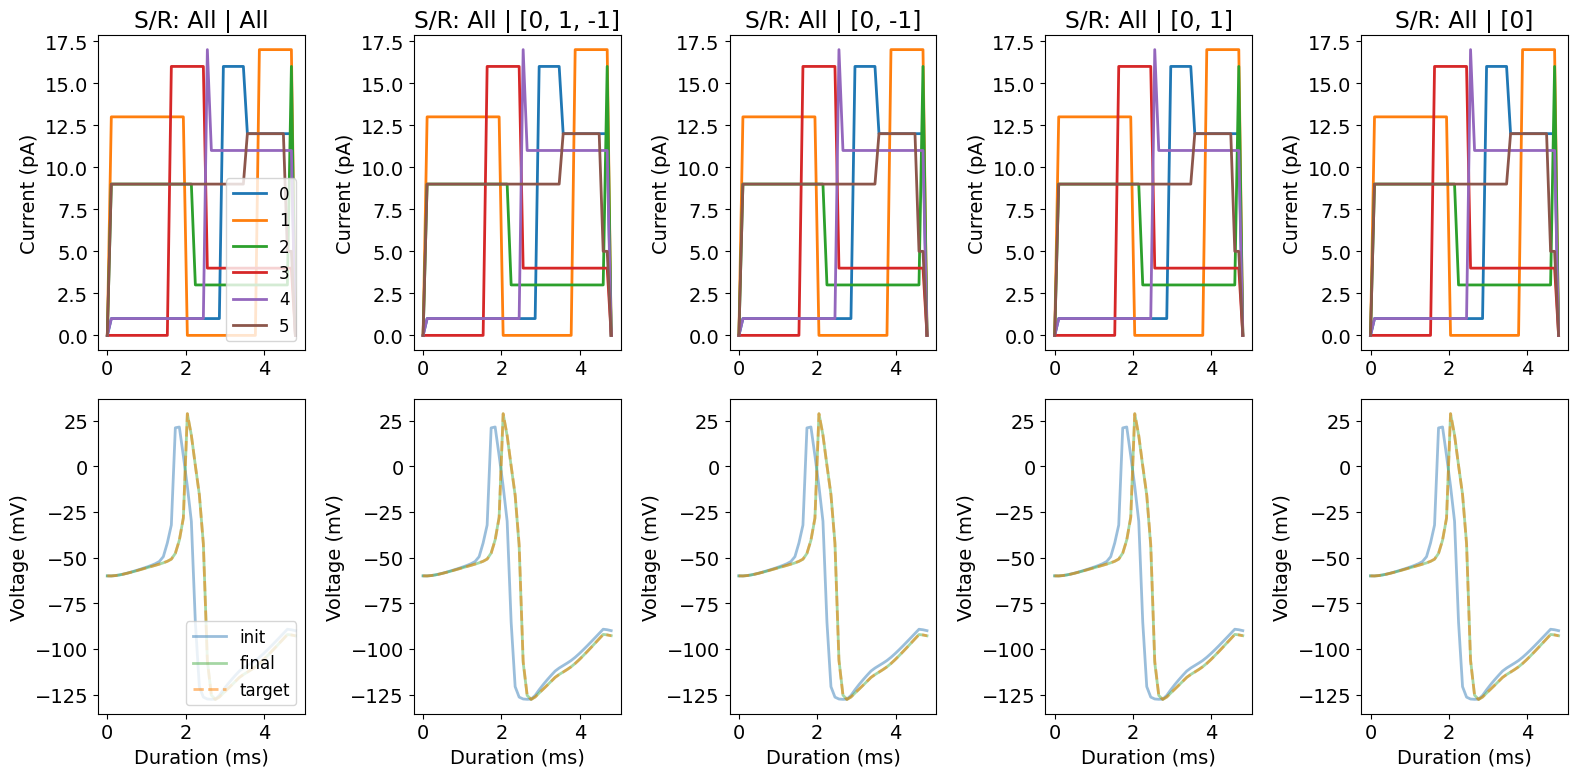

In [44]:
# Arrange condition indexes for plotting purposes
entry_ixs = fig_2_a_selected.index
entry_ixs = entry_ixs[np.array([4,3,2,1,0])]
print(entry_ixs)

# Normalize losses based on how many recording sites there are
norm_denom = np.array([6, 3, 2, 2, 1])

# Set hyperparameters
hyperparams = hyperparams_target

# Set xlim for plotting epochs
xlim_epochs = 200

# Set colors for plotting
num_colors = len(entry_ixs)
hues = np.linspace(0, 1, num_colors, endpoint=False)
rgb_colors = [mcolors.hsv_to_rgb([hue, 1.0, 1.0]) for hue in hues]
linewidth = 2
alpha = 0.8


# Figure Plot losses and ground truth errors
fig = plt.figure(figsize=(5, 8))

ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2)
ax4 = plt.subplot(3, 1, 3)


# Figure to Plot currents and voltage outputs
fig2, ax = plt.subplots(2, len(entry_ixs), figsize=(16, 8))

# Plot each data condition
for i, entry_ix in enumerate(entry_ixs):

    #### For Figure 3A ####
    
    # Load loss and parameter trajectories over training
    loss_curve = torch.load(data_lookup.loc[entry_ix]['loss_filename_id'])
    g_Na_curve = torch.load(data_lookup.loc[entry_ix]['g_Na_filename_id'])
    g_K_curve = torch.load(data_lookup.loc[entry_ix]['g_K_filename_id'])

    # Load target parameter generation settings
    center = data_lookup.loc[entry_ix]['mu']
    perturb = data_lookup.loc[entry_ix]['sigma']
    lin_nodes = data_lookup.loc[entry_ix]['lin_nodes']
    seed = data_lookup.loc[entry_ix]['seed']

    stim = data_lookup.loc[entry_ix]['stim_locations']
    rec = data_lookup.loc[entry_ix]['rec_locations']
    noise_sigma = data_lookup.loc[entry_ix]['noise_sigma']
    noise_flag = data_lookup.loc[entry_ix]['flag'] 

    # Rename "None" conditions to "All"
    if stim == None:
        stim = 'All'
    if rec == None:
        rec = 'All'

    # Generate target paramters
    g_targets = init_random_model_params(hyperparams=hyperparams_model,
                                             center=center,
                                             perturb=perturb,
                                             manual_seed=seed,
                                            )
    
    # Calculate distance between gt and trial params
    scaling = np.array([[100],[45]]) # Original parameter values for g_Na and g_K
    g_targets_scaled = g_targets * scaling
    gt_curve = np.empty((2,len(g_Na_curve)))
    gt_curve[0] = np.mean(np.abs(np.array((g_targets_scaled[0] - g_Na_curve))), 1)
    gt_curve[1] = np.mean(np.abs(np.array((g_targets_scaled[1] - g_K_curve))), 1)
    gt_curve = gt_curve.transpose()


    # Plot Normalized Loss
    ax1.plot(loss_curve/norm_denom[i], 
               linewidth=linewidth,
               label=f"S/R: {stim} | {rec}",
               color=rgb_colors[i],
               alpha=0.8,
              )

    # Plot g_Na ground truth error trajectory
    ax2.plot(gt_curve[:,0], 
           linewidth=linewidth,
           label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}",
           color=rgb_colors[i],
               alpha=0.8
          )
    # Plot g_K ground truth error trajectory
    ax4.plot(gt_curve[:,1], 
               linewidth=linewidth,
               label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}",
               color=rgb_colors[i],
               alpha=0.8
              )

    #### For Figure S1A-E

     # Load voltage and current traces
    volt_traces = load_voltage_traces_by_seed(fig_2_a_selected, 
                                              entry_ix=entry_ix, 
                                              hyperparams_target=hyperparams,
                                              noise_sigma=noise_sigma,
                                              noise_flag=noise_flag,
                                              )
    curr_traces = load_current_traces_by_seed(fig_2_a_selected, 
                                              entry_ix=entry_ix,
                                              hyperparams_target=hyperparams,
                                              noise_sigma=noise_sigma,
                                              noise_flag=noise_flag,
                                             )

    # Buid data frame of loaded voltage traces
    volt_traces_dict = {}
    labels = ['init','final','target']

    for k in range(len(labels)):
        for j in range(len(labels)):
            if labels[k] in (volt_traces[j][0]):
                volt_traces[j][1]
                volt_traces_dict[labels[k]] = volt_traces[j][1]

    volt_traces_df = pd.DataFrame([volt_traces_dict]).T
    
    # Visualize all voltage traces
    curr = curr_traces[0][1].shape

    volt_init = volt_traces_df.loc['init'][0]
    volt_final = volt_traces_df.loc['final'][0]
    volt_target = volt_traces_df.loc['target'][0]
    duration_volt = torch.linspace(0,len(volt_init[0,0,:,0]),len(volt_init[0,0,:,0])) * 0.1
    duration_curr = torch.linspace(0,curr[2],curr[2]) * 0.1

    
    neuron_num = 30 # example input/output pair

    # plot initial somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_init[neuron_num,0,:,0], 
                 color='#377eb8', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='init')
    # plot final somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_final[neuron_num,0,:,0], 
                 color='#4daf4a', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='final')
    # plot target somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_target[neuron_num,0,:,0], 
                 linestyle='dashed', 
                 color='#ff7f00', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='target') 
    # plot variable step currents
    for j in range(6):
        ax[0,i].plot(duration_curr.reshape(-1,1), 
                     curr_traces[0][1][neuron_num,:,:].transpose(1,0)[:,j], 
                     linewidth=2,
                     label=j)


    # Plot settings
    ax[0,i].set_ylabel('Current (pA)')
    ax[1,i].set_ylabel('Voltage (mV)')
    ax[1,i].set_xlabel('Duration (ms)')
    ax[0,i].set_title(f'S/R: {stim} | {rec}')
    ax[1,0].legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=12)
    ax[0,0].legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=12)


    ax1.set_ylim(0, 40)
    ax2.set_ylim(65, 130)
    ax4.set_ylim(30, 65)
    ax1.set_xlim(0,xlim_epochs)
    ax2.set_xlim(0,xlim_epochs)
    ax4.set_xlim(0,xlim_epochs)

    ax1.legend(loc='upper center', bbox_to_anchor=(0.7, 1), ncol=1, fontsize=12)

    ax2.set_ylim(0,20)
    ax4.set_ylim(0,20)
    ax2.set_xlim(0,xlim_epochs)
    ax4.set_xlim(0,xlim_epochs)

    ax1.set_ylabel('Normalized Loss')
    ax2.set_ylabel(r'Mean $g_{Na}$')
    ax4.set_ylabel(r'Mean $g_{K}$')

    ax4.set_xlabel('Epochs')

    ax2.set_ylabel(r'Mean GT error $g_{Na}$')
    ax4.set_ylabel(r'Mean GT error $g_{K}$')


fig.tight_layout()
fig2.tight_layout()


fig_2a_1_filename = 'Fig2a_1.svg'
fig_2a_2_filename = 'Fig2a_2.svg'

fig.savefig(PATH_images+fig_2a_1_filename, format='svg')
fig2.savefig(PATH_images+fig_2a_2_filename, format='svg')

plt.show()

### Table 2: Toy Model: Limit Recording Sites, Stimulate All Sites

In [45]:
# load loss_curve and calculate gt_curve for each entry_ix

loss_init = []
gt_init_g_Na = []
gt_init_g_K = []
loss_fin = []
gt_fin_g_Na = []
gt_fin_g_K = []
epoch_final = []
label_entry = []

for i, entry_ix in enumerate(entry_ixs):

    loss_curve = torch.load(data_lookup.loc[entry_ix]['loss_filename_id'])
    g_Na_curve = torch.load(data_lookup.loc[entry_ix]['g_Na_filename_id'])
    g_K_curve = torch.load(data_lookup.loc[entry_ix]['g_K_filename_id'])

    center = data_lookup.loc[entry_ix]['mu']
    perturb = data_lookup.loc[entry_ix]['sigma']
    lin_nodes = data_lookup.loc[entry_ix]['lin_nodes']
    seed = data_lookup.loc[entry_ix]['seed']

    stim = data_lookup.loc[entry_ix]['stim_locations']
    rec = data_lookup.loc[entry_ix]['rec_locations']
    noise_sigma = data_lookup.loc[entry_ix]['noise_sigma']
    noise_flag = data_lookup.loc[entry_ix]['flag']

    stim = data_lookup.loc[entry_ix]['stim_locations']
    rec = data_lookup.loc[entry_ix]['rec_locations']

    if stim == None:
        stim = 'All'
    if rec == None:
        rec = 'All'
    #         print(seed)

    g_targets = init_random_model_params(hyperparams=hyperparams_model,
                                             center=center,
                                             perturb=perturb,
                                             manual_seed=seed,
                                            )
    # Calculate distance between gt and trial params

    scaling = np.array([[100],[45]])
    g_targets_scaled = g_targets * scaling
    gt_curve = np.empty((2,len(g_Na_curve)))
    gt_curve[0] = np.mean(np.abs(np.array((g_targets_scaled[0] - g_Na_curve))), 1)
    gt_curve[1] = np.mean(np.abs(np.array((g_targets_scaled[1] - g_K_curve))), 1)
    gt_curve = gt_curve.transpose()

    loss_init.append(loss_curve[0].item())
    loss_fin.append(loss_curve[-1].item())
    gt_init_g_Na.append(gt_curve[0][0].item())
    gt_fin_g_Na.append(gt_curve[-1][0].item())
    gt_init_g_K.append(gt_curve[0][1].item())
    gt_fin_g_K.append(gt_curve[-1][1].item())
    epoch_final.append(len(loss_curve))
    label_entry.append(f"{stim} | {rec}")

data_df = pd.DataFrame({
    'Condition S/R'     : label_entry,
    'Seed'          : data_lookup['seed'],
    'Initial Normalized Loss': loss_init/norm_denom,
    'Final Normalized Loss': loss_fin/norm_denom,
    'Initial g_Na GTE': gt_init_g_Na,
    'Final g_Na GTE': gt_fin_g_Na,
    'Initial g_K GTE': gt_init_g_K,
    'Final g_K GTE': gt_fin_g_K,
    'Total Epochs': epoch_final,
}, index=entry_ixs).round(3).transpose()

data_df_filename = 'Fig2a_data.csv'
data_df.to_csv(PATH_images+data_df_filename)

# print out latex table format of dataframe
print(data_df.to_latex())
data_df

\begin{tabular}{llllll}
\toprule
{} &          8 &                 7 &              6 &             5 &          4 \\
\midrule
Condition S/R           &  All | All &  All | [0, 1, -1] &  All | [0, -1] &  All | [0, 1] &  All | [0] \\
Seed                    &   20230619 &          20230619 &       20230619 &      20230619 &   20230619 \\
Initial Normalized Loss &      5.709 &             7.132 &          7.215 &          6.82 &      6.674 \\
Final Normalized Loss   &      0.001 &             0.003 &          0.006 &         0.002 &      0.011 \\
Initial g\_Na GTE        &      16.58 &            16.747 &         16.747 &        16.747 &     16.747 \\
Final g\_Na GTE          &      0.318 &             1.196 &          2.266 &         3.128 &      4.821 \\
Initial g\_K GTE         &      7.382 &             7.215 &          7.215 &         7.215 &      7.215 \\
Final g\_K GTE           &      0.207 &              0.82 &          1.681 &         2.113 &      3.546 \\
Total Epochs         

/tmp/ipykernel_2774013/3602488543.py:79: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_df.to_latex())


,8,7,6,5,4
Condition S/R,All | All,"All | [0, 1, -1]","All | [0, -1]","All | [0, 1]",All | [0]
Seed,20230619,20230619,20230619,20230619,20230619
Initial Normalized Loss,5.709,7.132,7.215,6.82,6.674
Final Normalized Loss,0.001,0.003,0.006,0.002,0.011
Initial g_Na GTE,16.58,16.747,16.747,16.747,16.747
Final g_Na GTE,0.318,1.196,2.266,3.128,4.821
Initial g_K GTE,7.382,7.215,7.215,7.215,7.215
Final g_K GTE,0.207,0.82,1.681,2.113,3.546
Total Epochs,200,200,200,200,200


In [46]:
loss_ratio = (1-np.array(loss_fin) / np.array(loss_init))*100
g_Na_ratio = (1-np.array(gt_fin_g_Na) / np.array(gt_init_g_Na))*100
g_K_ratio = (1-np.array(gt_fin_g_K) / np.array(gt_init_g_K))*100

data_df_ratio = pd.DataFrame({
    'Condition S/R'     : label_entry,
    'Seed'          : data_lookup['seed'],
    'Initial Normalized Loss': loss_init/norm_denom,
    'Final Normalized Loss': loss_fin/norm_denom,
    'Loss Decrease (%)': loss_ratio,
    'Initial g_Na GTE': gt_init_g_Na,
    'Final g_Na GTE': gt_fin_g_Na,
    'g_Na GTE Decrease (%)': g_Na_ratio,
    'Initial g_K GTE': gt_init_g_K,
    'Final g_K GTE': gt_fin_g_K,
    'g_K GTE Decrease (%)': g_K_ratio,
    'Total Epochs': epoch_final,
}, index=entry_ixs).round(3).transpose()

data_df_ratio

data_df_ratio_filename = 'Fig2a_data_ratio.csv'
data_df_ratio.to_csv(PATH_images+data_df_ratio_filename)

# print out latex table format of dataframe
print(data_df_ratio.to_latex())
data_df_ratio


\begin{tabular}{llllll}
\toprule
{} &          8 &                 7 &              6 &             5 &          4 \\
\midrule
Condition S/R           &  All | All &  All | [0, 1, -1] &  All | [0, -1] &  All | [0, 1] &  All | [0] \\
Seed                    &   20230619 &          20230619 &       20230619 &      20230619 &   20230619 \\
Initial Normalized Loss &      5.709 &             7.132 &          7.215 &          6.82 &      6.674 \\
Final Normalized Loss   &      0.001 &             0.003 &          0.006 &         0.002 &      0.011 \\
Loss Decrease (\%)       &     99.983 &            99.964 &         99.913 &        99.967 &     99.842 \\
Initial g\_Na GTE        &      16.58 &            16.747 &         16.747 &        16.747 &     16.747 \\
Final g\_Na GTE          &      0.318 &             1.196 &          2.266 &         3.128 &      4.821 \\
g\_Na GTE Decrease (\%)   &     98.082 &             92.86 &         86.466 &        81.321 &      71.21 \\
Initial g\_K GTE    

/tmp/ipykernel_2774013/142781415.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_df_ratio.to_latex())


,8,7,6,5,4
Condition S/R,All | All,"All | [0, 1, -1]","All | [0, -1]","All | [0, 1]",All | [0]
Seed,20230619,20230619,20230619,20230619,20230619
Initial Normalized Loss,5.709,7.132,7.215,6.82,6.674
Final Normalized Loss,0.001,0.003,0.006,0.002,0.011
Loss Decrease (%),99.983,99.964,99.913,99.967,99.842
Initial g_Na GTE,16.58,16.747,16.747,16.747,16.747
Final g_Na GTE,0.318,1.196,2.266,3.128,4.821
g_Na GTE Decrease (%),98.082,92.86,86.466,81.321,71.21
Initial g_K GTE,7.382,7.215,7.215,7.215,7.215
Final g_K GTE,0.207,0.82,1.681,2.113,3.546


In [48]:
# Initialize an EventAccumulator
event_acc_1 = EventAccumulator('./runs/20240621-071406_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718968446.holygpu8a19605.rc.fas.harvard.edu.1278302.16')
event_acc_2 = EventAccumulator('./runs/20240621-023601_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718951761.holygpu8a19605.rc.fas.harvard.edu.1278302.14')
event_acc_3 = EventAccumulator('./runs/20240620-215426_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718934866.holygpu8a19605.rc.fas.harvard.edu.1278302.12')
event_acc_4 = EventAccumulator('./runs/20240620-171114_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718917874.holygpu8a19605.rc.fas.harvard.edu.1278302.10')
event_acc_5 = EventAccumulator('./runs/20240620-122911_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718900951.holygpu8a19605.rc.fas.harvard.edu.1278302.8')
event_acc_list = [event_acc_1, event_acc_2, event_acc_3, event_acc_4, event_acc_5]

walltime_total, walltime_per_epoch, epoch_final = [], [], []

for event_acc in event_acc_list:
    # Load the events from the file
    event_acc.Reload()

    # Calculate wall time
    epoch_fin = len(event_acc.Scalars('Total Loss'))
    wall_time_start = event_acc.Scalars('Total Loss')[0].wall_time
    wall_time_end = event_acc.Scalars('Total Loss')[-1].wall_time

    # Convert wall_time to datetime objects
    start_dt = datetime.datetime.fromtimestamp(wall_time_start)
    end_dt = datetime.datetime.fromtimestamp(wall_time_end)
    
    # Calculate the difference
    time_difference = end_dt - start_dt
    
    # Extract hours, minutes, and seconds from the time difference
    total_seconds = time_difference.total_seconds()
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    
    # Print the result
    print(f"Duration: {hours} hours, {minutes} minutes, {seconds} seconds")

    epoch_final.append(int(epoch_fin))
    walltime_total.append(f'{int(hours)}:{int(minutes)}:{int(seconds)}')

print(walltime_total)

Duration: 4 hours, 38 minutes, 21 seconds
Duration: 4 hours, 36 minutes, 26 seconds
Duration: 4 hours, 39 minutes, 56 seconds
Duration: 4 hours, 41 minutes, 33 seconds
Duration: 4 hours, 40 minutes, 23 seconds
['4:38:21', '4:36:26', '4:39:56', '4:41:33', '4:40:23']


#### Final Table

In [49]:
loss_ratio = (1-np.array(loss_fin) / np.array(loss_init))*100
g_Na_ratio = (1-np.array(gt_fin_g_Na) / np.array(gt_init_g_Na))*100
g_K_ratio = (1-np.array(gt_fin_g_K) / np.array(gt_init_g_K))*100

data_df_ratio = pd.DataFrame({
    'Condition S/R'     : label_entry,
    'Seed'          : data_lookup['seed'],
    'Initial Loss': loss_init,
    'Final Loss': loss_fin,
    'Loss Decrease (%)': loss_ratio,
    'Initial g_Na GTE': gt_init_g_Na,
    'Final g_Na GTE': gt_fin_g_Na,
    'g_Na GTE Decrease (%)': g_Na_ratio,
    'Initial g_K GTE': gt_init_g_K,
    'Final g_K GTE': gt_fin_g_K,
    'g_K GTE Decrease (%)': g_K_ratio,
    'Total Epochs': epoch_final,
    'Optimization Time (H:M:S)': walltime_total
}, index=entry_ixs).round(3).transpose()

data_df_ratio

data_df_ratio_filename = 'Fig2b_data_ratio.csv'
data_df_ratio.to_csv(PATH_images+data_df_ratio_filename)

# print out latex table format of dataframe
print(data_df_ratio.to_latex())
data_df_ratio

\begin{tabular}{llllll}
\toprule
{} &          8 &                 7 &              6 &             5 &          4 \\
\midrule
Condition S/R             &  All | All &  All | [0, 1, -1] &  All | [0, -1] &  All | [0, 1] &  All | [0] \\
Seed                      &   20230619 &          20230619 &       20230619 &      20230619 &   20230619 \\
Initial Loss              &     34.256 &            21.396 &         14.431 &         13.64 &      6.674 \\
Final Loss                &      0.006 &             0.008 &          0.012 &         0.004 &      0.011 \\
Loss Decrease (\%)         &     99.983 &            99.964 &         99.913 &        99.967 &     99.842 \\
Initial g\_Na GTE          &      16.58 &            16.747 &         16.747 &        16.747 &     16.747 \\
Final g\_Na GTE            &      0.318 &             1.196 &          2.266 &         3.128 &      4.821 \\
g\_Na GTE Decrease (\%)     &     98.082 &             92.86 &         86.466 &        81.321 &      71.21 \\
Init

/tmp/ipykernel_2774013/1778472565.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_df_ratio.to_latex())


,8,7,6,5,4
Condition S/R,All | All,"All | [0, 1, -1]","All | [0, -1]","All | [0, 1]",All | [0]
Seed,20230619,20230619,20230619,20230619,20230619
Initial Loss,34.256,21.396,14.431,13.64,6.674
Final Loss,0.006,0.008,0.012,0.004,0.011
Loss Decrease (%),99.983,99.964,99.913,99.967,99.842
Initial g_Na GTE,16.58,16.747,16.747,16.747,16.747
Final g_Na GTE,0.318,1.196,2.266,3.128,4.821
g_Na GTE Decrease (%),98.082,92.86,86.466,81.321,71.21
Initial g_K GTE,7.382,7.215,7.215,7.215,7.215
Final g_K GTE,0.207,0.82,1.681,2.113,3.546


## Fig3B, FigS1F-J: Experimental Conditions - Record All, Limit Stimulation

### Generate Traces

In [50]:
# Select traces for the "Limit Stimulations, Record All" semi-ideal data conditions
fig_2_b_selected = data_lookup[data_lookup.apply(lambda row: row['rec_locations'] == None, axis=1)]
fig_2_b_selected

,stim_locations,rec_locations,noise_sigma,flag,mu,sigma,lin_nodes,distribution,seed,loss_filename_exists,g_Na_filename_exists,g_K_filename_exists,loss_filename_id,g_Na_filename_id,g_K_filename_id
0,[0],None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
1,"[0, 1]",None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
2,"[0, -1]",None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
3,"[0, 1, -1]",None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...
8,None,None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...


In [51]:
# Generate initial, final, and target voltage traces for each data condition
if GENERATE_TRACES == True:
    entry_ixs = fig_2_b_selected.index
    for entry_ix in entry_ixs:
        generate_all_voltage_traces(data_lookup, entry_ix=entry_ix, hyperparams=hyperparams_target)

### 2a.1-2: The figure

Int64Index([8, 3, 2, 1, 0], dtype='int64')
Matching Files:
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_init_nodes_6_dist_manual_mu_1.0_sigma_0.0_stim_all_rec_all_noise_0_flag_False.pth
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_final_nodes_6_dist_manual_mu_1.0_sigma_0.0_stim_all_rec_all_noise_0_flag_False.pth
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_target_nodes_6_dist_manual_mu_1.0_sigma_0.3_stim_all_rec_all_noise_0_flag_False.pth
Matching Files:
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/current_trace_nodes_6_dist_manual_mu_1.0_sigma_0.0_stim_all_rec_all_noise_0_flag_False.pth
Matching Files:
./results/20240617/targ_nodes_6_dist_manual_mu_1.0_sigma_0.3/seed_20230619/lr_0.5/voltage_trace_final_nodes_6_dist_manual_mu_1.0_sigma_0.0_stim_0_1_-1_rec_all_noise_0_flag_False.pth
./results/2024061

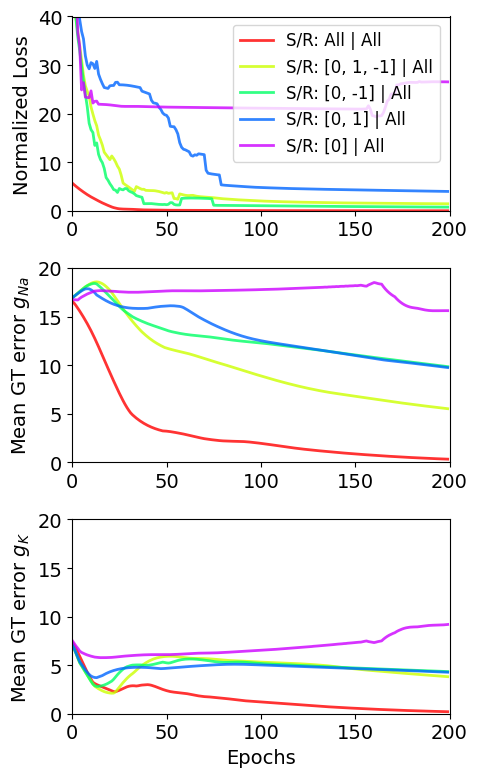

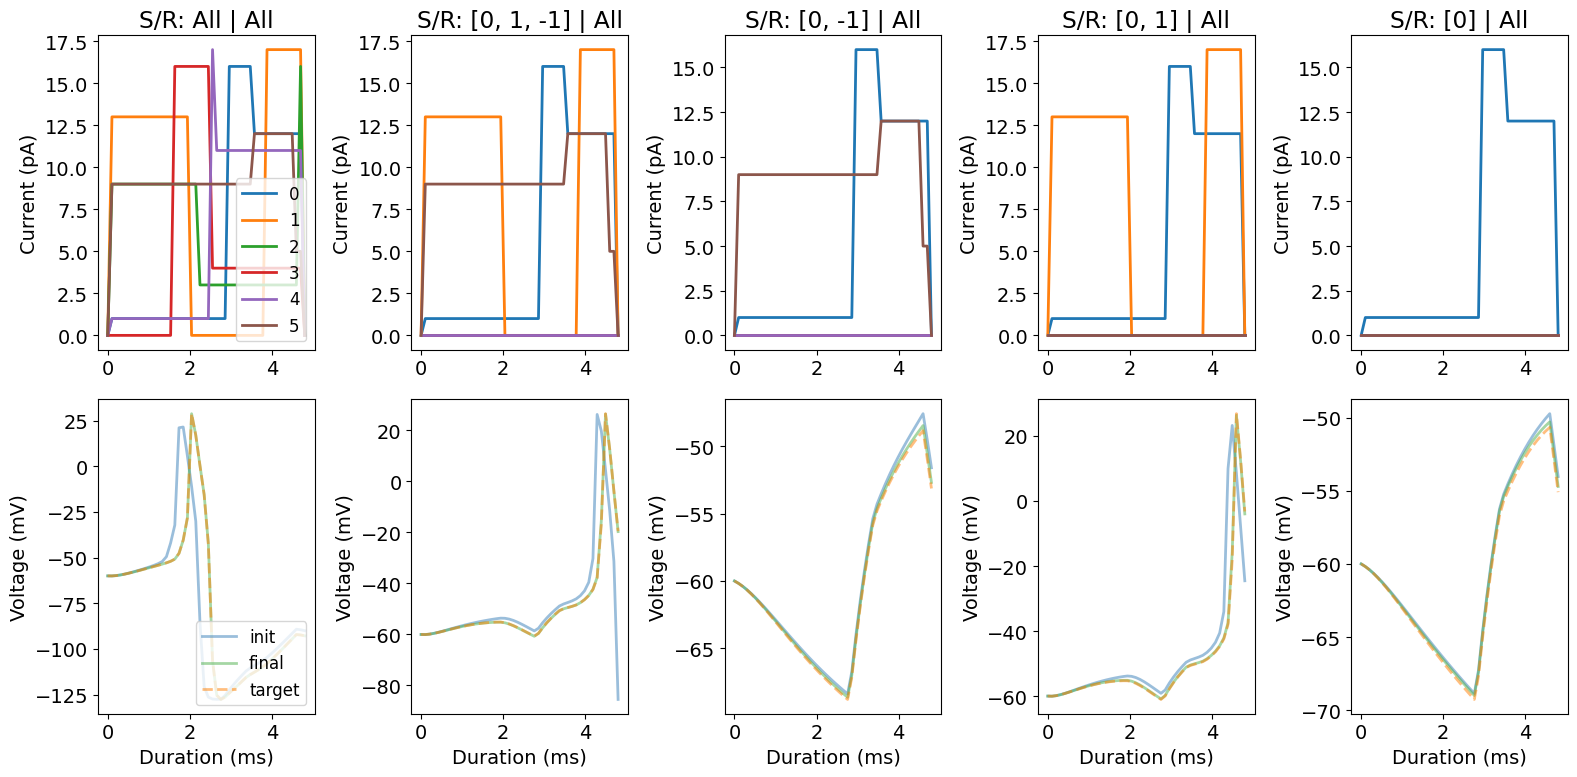

In [52]:
# Arrange condition indexes for plotting purposes
entry_ixs = fig_2_b_selected.index
entry_ixs = entry_ixs[np.array([4,3,2,1,0])]
print(entry_ixs)

# Normalize losses based on how many recording sites there are
norm_denom = np.array([6,6,6,6,6])

# Set hyperparameters
hyperparams = hyperparams_target

# Set xlim for plotting epochs
xlim_epochs = 200

# Set colors for plotting
num_colors = len(entry_ixs)
hues = np.linspace(0, 1, num_colors, endpoint=False)
rgb_colors = [mcolors.hsv_to_rgb([hue, 1.0, 1.0]) for hue in hues]
linewidth = 2
alpha = 0.8

# Figure Plot losses and ground truth errors
fig = plt.figure(figsize=(5, 8))


ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2)
ax4 = plt.subplot(3, 1, 3)

# Figure to Plot currents and voltage outputs
fig2, ax = plt.subplots(2, len(entry_ixs), figsize=(16, 8))

# Plot each data condition
for i, entry_ix in enumerate(entry_ixs):

    #### For Figure 3B ####

    # Load loss and parameter trajectories over training
    loss_curve = torch.load(data_lookup.loc[entry_ix]['loss_filename_id'])
    g_Na_curve = torch.load(data_lookup.loc[entry_ix]['g_Na_filename_id'])
    g_K_curve = torch.load(data_lookup.loc[entry_ix]['g_K_filename_id'])
    
    # Load target parameter generation settings
    center = data_lookup.loc[entry_ix]['mu']
    perturb = data_lookup.loc[entry_ix]['sigma']
    lin_nodes = data_lookup.loc[entry_ix]['lin_nodes']
    seed = data_lookup.loc[entry_ix]['seed']

    stim = data_lookup.loc[entry_ix]['stim_locations']
    rec = data_lookup.loc[entry_ix]['rec_locations']
    noise_sigma = data_lookup.loc[entry_ix]['noise_sigma']
    noise_flag = data_lookup.loc[entry_ix]['flag']
    
    # Rename "None" conditions to "All"
    if stim == None:
        stim = 'All'
    if rec == None:
        rec = 'All'
   
    # Generate target paramters
    g_targets = init_random_model_params(hyperparams=hyperparams_model,
                                             center=center,
                                             perturb=perturb,
                                             manual_seed=seed,
                                            )
    
    # Calculate distance between gt and trial params
    scaling = np.array([[100],[45]]) # Original parameter values for g_Na and g_K
    g_targets_scaled = g_targets * scaling
    gt_curve = np.empty((2,len(g_Na_curve)))
    gt_curve[0] = np.mean(np.abs(np.array((g_targets_scaled[0] - g_Na_curve))), 1)
    gt_curve[1] = np.mean(np.abs(np.array((g_targets_scaled[1] - g_K_curve))), 1)
    gt_curve = gt_curve.transpose()

    # Plot Normalized Loss
    ax1.plot(loss_curve/norm_denom[i], 
               linewidth=linewidth,
               label=f"S/R: {stim} | {rec}",
               color=rgb_colors[i],
               alpha=0.8,
              )
    # Plot g_Na ground truth error trajectory
    ax2.plot(gt_curve[:,0], 
           linewidth=linewidth,
           label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}",
           color=rgb_colors[i],
               alpha=0.8
          )
    # Plot g_K ground truth error trajectory
    ax4.plot(gt_curve[:,1], 
               linewidth=linewidth,
               label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}",
               color=rgb_colors[i],
               alpha=0.8
              )

    #### For Figure S1F-J ####

    
     # Load voltage traces and current traces
    volt_traces = load_voltage_traces_by_seed(fig_2_b_selected, 
                                              entry_ix=entry_ix, 
                                              hyperparams_target=hyperparams,
                                              noise_sigma=noise_sigma,
                                              noise_flag=noise_flag,
                                              )
    curr_traces = load_current_traces_by_seed(fig_2_b_selected, 
                                              entry_ix=entry_ix,
                                              hyperparams_target=hyperparams,
                                              noise_sigma=noise_sigma,
                                              noise_flag=noise_flag,
                                             )

    # Buid data frame of loaded voltage traces
    volt_traces_dict = {}
    labels = ['init','final','target']

    for k in range(len(labels)):
        for j in range(len(labels)):
            if labels[k] in (volt_traces[j][0]):
                volt_traces[j][1]
                volt_traces_dict[labels[k]] = volt_traces[j][1]

    volt_traces_df = pd.DataFrame([volt_traces_dict]).T

    
    # Visualize all voltage traces, find a current value that works
    curr = curr_traces[0][1].shape

    volt_init = volt_traces_df.loc['init'][0]
    volt_final = volt_traces_df.loc['final'][0]
    volt_target = volt_traces_df.loc['target'][0]
    duration_volt = torch.linspace(0,len(volt_init[0,0,:,0]),len(volt_init[0,0,:,0])) * 0.1
    duration_curr = torch.linspace(0,curr[2],curr[2]) * 0.1

    
    neuron_num = 30 # example input/output pair
    
    # plot initial somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_init[neuron_num,0,:,0], 
                 color='#377eb8', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='init')
    # plot final somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_final[neuron_num,0,:,0], 
                 color='#4daf4a', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='final')
    # plot target somatic voltage trace
    ax[1,i].plot(duration_volt, 
                 volt_target[neuron_num,0,:,0], 
                 linestyle='dashed', 
                 color='#ff7f00', 
                 alpha=0.5, 
                 linewidth=2, 
                 label='target')
    # plot variable step currents
    for j in range(6):
        ax[0,i].plot(duration_curr.reshape(-1,1), 
                     curr_traces[0][1][neuron_num,:,:].transpose(1,0)[:,j], 
                     linewidth=2,
                     label=j)


    # Plot settings
    ax[0,i].set_ylabel('Current (pA)')
    ax[1,i].set_ylabel('Voltage (mV)')
    ax[1,i].set_xlabel('Duration (ms)')
    ax[0,i].set_title(f'S/R: {stim} | {rec}')
    ax[1,0].legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=12)
    ax[0,0].legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize=12)

    ax1.set_ylim(0, 40)
    ax2.set_ylim(65, 130)
    ax4.set_ylim(30, 65)
    ax1.set_xlim(0,xlim_epochs)
    ax2.set_xlim(0,xlim_epochs)
    ax4.set_xlim(0,xlim_epochs)

    ax1.legend(loc='upper center', bbox_to_anchor=(0.7, 1), ncol=1, fontsize=12)

    ax2.set_ylim(0,20)
    ax4.set_ylim(0,20)
    ax2.set_xlim(0,xlim_epochs)
    ax4.set_xlim(0,xlim_epochs)

    ax1.set_ylabel('Normalized Loss')
    ax2.set_ylabel(r'Mean $g_{Na}$')
    ax4.set_ylabel(r'Mean $g_{K}$')

    ax4.set_xlabel('Epochs')


    ax2.set_ylabel(r'Mean GT error $g_{Na}$')
    ax4.set_ylabel(r'Mean GT error $g_{K}$')

fig.tight_layout()
fig2.tight_layout()


fig_2b_1_filename = 'Fig2b_1.svg'
fig_2b_2_filename = 'Fig2b_2.svg'

fig.savefig(PATH_images+fig_2b_1_filename, format='svg')
fig2.savefig(PATH_images+fig_2b_2_filename, format='svg')

plt.show()

### Table 2: Toy Model: Limit Stimulation Sites, Record All Sites

In [53]:
# load loss_curve and calculate gt_curve for each entry_ix

loss_init = []
gt_init_g_Na = []
gt_init_g_K = []
loss_fin = []
gt_fin_g_Na = []
gt_fin_g_K = []
epoch_final = []
label_entry = []

for i, entry_ix in enumerate(entry_ixs):
# entry_ix = entry_ixs[0]
    loss_curve = torch.load(data_lookup.loc[entry_ix]['loss_filename_id'])
    g_Na_curve = torch.load(data_lookup.loc[entry_ix]['g_Na_filename_id'])
    g_K_curve = torch.load(data_lookup.loc[entry_ix]['g_K_filename_id'])

    if len(loss_curve) > 200:
        loss_curve = loss_curve[:200]
        g_Na_curve = g_Na_curve[:200]
        g_K_curve = g_K_curve[:200]

    center = data_lookup.loc[entry_ix]['mu']
    perturb = data_lookup.loc[entry_ix]['sigma']
    lin_nodes = data_lookup.loc[entry_ix]['lin_nodes']
    seed = data_lookup.loc[entry_ix]['seed']

    stim = data_lookup.loc[entry_ix]['stim_locations']
    rec = data_lookup.loc[entry_ix]['rec_locations']
    noise_sigma = data_lookup.loc[entry_ix]['noise_sigma']
    noise_flag = data_lookup.loc[entry_ix]['flag']

    stim = data_lookup.loc[entry_ix]['stim_locations']
    rec = data_lookup.loc[entry_ix]['rec_locations']

    if stim == None:
        stim = 'All'
    if rec == None:
        rec = 'All'
    #         print(seed)

    g_targets = init_random_model_params(hyperparams=hyperparams_model,
                                             center=center,
                                             perturb=perturb,
                                             manual_seed=seed,
                                            )
    # Calculate distance between gt and trial params

    scaling = np.array([[100],[45]])
    g_targets_scaled = g_targets * scaling
    gt_curve = np.empty((2,len(g_Na_curve)))
    gt_curve[0] = np.mean(np.abs(np.array((g_targets_scaled[0] - g_Na_curve))), 1)
    gt_curve[1] = np.mean(np.abs(np.array((g_targets_scaled[1] - g_K_curve))), 1)
    gt_curve = gt_curve.transpose()

    loss_init.append(loss_curve[0].item())
    loss_fin.append(loss_curve[-1].item())
    gt_init_g_Na.append(gt_curve[0][0].item())
    gt_fin_g_Na.append(gt_curve[-1][0].item())
    gt_init_g_K.append(gt_curve[0][1].item())
    gt_fin_g_K.append(gt_curve[-1][1].item())
    epoch_final.append(len(loss_curve))
    label_entry.append(f"{stim} | {rec}")

data_df = pd.DataFrame({
    'Condition S/R'     : label_entry,
    'Seed'          : data_lookup['seed'],
    'Initial Loss': loss_init,
    'Final Loss': loss_fin,
    'Initial g_Na GTE': gt_init_g_Na,
    'Final g_Na GTE': gt_fin_g_Na,
    'Initial g_K GTE': gt_init_g_K,
    'Final g_K GTE': gt_fin_g_K,
    'Total Epochs': epoch_final,
}, index=entry_ixs).round(3).transpose()

data_df

data_df_filename = 'Fig2a_data.csv'
data_df.to_csv(PATH_images+data_df_filename)

# print out latex table format of dataframe
print(data_df.to_latex())
data_df

\begin{tabular}{llllll}
\toprule
{} &          8 &                 3 &              2 &             1 &          0 \\
\midrule
Condition S/R    &  All | All &  [0, 1, -1] | All &  [0, -1] | All &  [0, 1] | All &  [0] | All \\
Seed             &   20230619 &          20230619 &       20230619 &      20230619 &   20230619 \\
Initial Loss     &     34.256 &           278.534 &        284.367 &       315.122 &    301.027 \\
Final Loss       &      0.006 &             8.631 &          4.489 &        23.878 &    159.241 \\
Initial g\_Na GTE &      16.58 &            16.914 &         16.914 &        16.914 &     16.747 \\
Final g\_Na GTE   &      0.318 &             5.513 &          9.844 &         9.748 &     15.605 \\
Initial g\_K GTE  &      7.382 &             7.215 &          7.215 &         7.215 &      7.548 \\
Final g\_K GTE    &      0.207 &             3.814 &          4.342 &         4.272 &      9.189 \\
Total Epochs     &        200 &               200 &            200 &         

/tmp/ipykernel_2774013/4100755758.py:83: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_df.to_latex())


,8,3,2,1,0
Condition S/R,All | All,"[0, 1, -1] | All","[0, -1] | All","[0, 1] | All",[0] | All
Seed,20230619,20230619,20230619,20230619,20230619
Initial Loss,34.256,278.534,284.367,315.122,301.027
Final Loss,0.006,8.631,4.489,23.878,159.241
Initial g_Na GTE,16.58,16.914,16.914,16.914,16.747
Final g_Na GTE,0.318,5.513,9.844,9.748,15.605
Initial g_K GTE,7.382,7.215,7.215,7.215,7.548
Final g_K GTE,0.207,3.814,4.342,4.272,9.189
Total Epochs,200,200,200,200,200


In [54]:
# Initialize an EventAccumulator
event_acc_1 = EventAccumulator('./runs/20240621-071406_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718968446.holygpu8a19605.rc.fas.harvard.edu.1278302.16')
event_acc_2 = EventAccumulator('./runs/20240620-080846_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718885326.holygpu8a19605.rc.fas.harvard.edu.1278302.6')
event_acc_3 = EventAccumulator('./runs/20240620-030803_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718867283.holygpu8a19605.rc.fas.harvard.edu.1278302.4')
event_acc_4 = EventAccumulator('./runs/20240619-184132_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718836892.holygpu8a19605.rc.fas.harvard.edu.1278302.2')
event_acc_5 = EventAccumulator('./runs/20240619-104008_model_1.0_0.0_target_1.0_0.3_20230619/events.out.tfevents.1718808008.holygpu8a19605.rc.fas.harvard.edu.1278302.0')
event_acc_list = [event_acc_1, event_acc_2, event_acc_3, event_acc_4, event_acc_5]

walltime_total, walltime_per_epoch, epoch_final = [], [], []

for event_acc in event_acc_list:
    # Load the events from the file
    event_acc.Reload()

    # Calculate wall time
    epoch_fin = len(event_acc.Scalars('Total Loss'))
    wall_time_start = event_acc.Scalars('Total Loss')[0].wall_time
    wall_time_end = event_acc.Scalars('Total Loss')[-1].wall_time

    # Convert wall_time to datetime objects
    start_dt = datetime.datetime.fromtimestamp(wall_time_start)
    end_dt = datetime.datetime.fromtimestamp(wall_time_end)
    
    # Calculate the difference
    time_difference = end_dt - start_dt
    
    # Extract hours, minutes, and seconds from the time difference
    total_seconds = time_difference.total_seconds()
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    
    # Print the result
    print(f"Duration: {hours} hours, {minutes} minutes, {seconds} seconds")

    epoch_final.append(int(epoch_fin))
    walltime_total.append(f'{int(hours)}:{int(minutes)}:{int(seconds)}')

print(walltime_total)

Duration: 4 hours, 38 minutes, 21 seconds
Duration: 4 hours, 18 minutes, 47 seconds
Duration: 4 hours, 57 minutes, 49 seconds
Duration: 8 hours, 23 minutes, 16 seconds
Duration: 7 hours, 58 minutes, 22 seconds
['4:38:21', '4:18:47', '4:57:49', '8:23:16', '7:58:22']


#### Final Table

In [56]:
loss_ratio = (1-np.array(loss_fin) / np.array(loss_init))*100
g_Na_ratio = (1-np.array(gt_fin_g_Na) / np.array(gt_init_g_Na))*100
g_K_ratio = (1-np.array(gt_fin_g_K) / np.array(gt_init_g_K))*100

data_df_ratio = pd.DataFrame({
    'Condition S/R'     : label_entry,
    'Seed'          : data_lookup['seed'],
    'Initial Normalized Loss': loss_init/norm_denom,
    'Final Normalized Loss': loss_fin/norm_denom,
    'Loss Decrease (%)': loss_ratio,
    'Initial g_Na GTE': gt_init_g_Na,
    'Final g_Na GTE': gt_fin_g_Na,
    'g_Na GTE Decrease (%)': g_Na_ratio,
    'Initial g_K GTE': gt_init_g_K,
    'Final g_K GTE': gt_fin_g_K,
    'g_K GTE Decrease (%)': g_K_ratio,
    'Total Epochs': epoch_final,
    'Optimization Time (H:M:S)': walltime_total
}, index=entry_ixs).round(3).transpose()

data_df_ratio

data_df_ratio_filename = 'Fig2b_data_ratio.csv'
data_df_ratio.to_csv(PATH_images+data_df_ratio_filename)

# print out latex table format of dataframe
print(data_df_ratio.to_latex())
data_df_ratio


\begin{tabular}{llllll}
\toprule
{} &          8 &                 3 &              2 &             1 &          0 \\
\midrule
Condition S/R             &  All | All &  [0, 1, -1] | All &  [0, -1] | All &  [0, 1] | All &  [0] | All \\
Seed                      &   20230619 &          20230619 &       20230619 &      20230619 &   20230619 \\
Initial Normalized Loss   &      5.709 &            46.422 &         47.394 &         52.52 &     50.171 \\
Final Normalized Loss     &      0.001 &             1.439 &          0.748 &          3.98 &      26.54 \\
Loss Decrease (\%)         &     99.983 &            96.901 &         98.422 &        92.423 &     47.101 \\
Initial g\_Na GTE          &      16.58 &            16.914 &         16.914 &        16.914 &     16.747 \\
Final g\_Na GTE            &      0.318 &             5.513 &          9.844 &         9.748 &     15.605 \\
g\_Na GTE Decrease (\%)     &     98.082 &            67.407 &         41.799 &        42.366 &       6.82 \\
Init

/tmp/ipykernel_2774013/2084338147.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_df_ratio.to_latex())


,8,3,2,1,0
Condition S/R,All | All,"[0, 1, -1] | All","[0, -1] | All","[0, 1] | All",[0] | All
Seed,20230619,20230619,20230619,20230619,20230619
Initial Normalized Loss,5.709,46.422,47.394,52.52,50.171
Final Normalized Loss,0.001,1.439,0.748,3.98,26.54
Loss Decrease (%),99.983,96.901,98.422,92.423,47.101
Initial g_Na GTE,16.58,16.914,16.914,16.914,16.747
Final g_Na GTE,0.318,5.513,9.844,9.748,15.605
g_Na GTE Decrease (%),98.082,67.407,41.799,42.366,6.82
Initial g_K GTE,7.382,7.215,7.215,7.215,7.548
Final g_K GTE,0.207,3.814,4.342,4.272,9.189


## Figure 2: Demonstration of Parameter Optimization using Backprop

In [21]:
# Select traces for the "Limit Recordings, Stimulate All" semi-ideal data conditions
fig_1_selected = data_lookup[data_lookup.apply(lambda row: (row['rec_locations'] == None and row['stim_locations'] == None) , axis=1)]
fig_1_selected

,stim_locations,rec_locations,noise_sigma,flag,mu,sigma,lin_nodes,distribution,seed,loss_filename_exists,g_Na_filename_exists,g_K_filename_exists,loss_filename_id,g_Na_filename_id,g_K_filename_id
8,None,None,0,False,1.0,0.3,6,manual,20230619,True,True,True,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...,./results/20240617/targ_nodes_6_dist_manual_mu...


In [22]:
# Generate initial, final, and target voltage traces for each data condition
if GENERATE_TRACES == True:
    entry_ixs = fig_1_selected.index
    entry_ix = entry_ixs[0]
    print(entry_ix)
    # for entry_ix in entry_ixs:
    generate_all_voltage_traces(data_lookup, entry_ix=entry_ix,hyperparams=hyperparams_target)

In [23]:
plt.rcParams['font.size'] = 14

## Figure 2

Int64Index([8], dtype='int64')


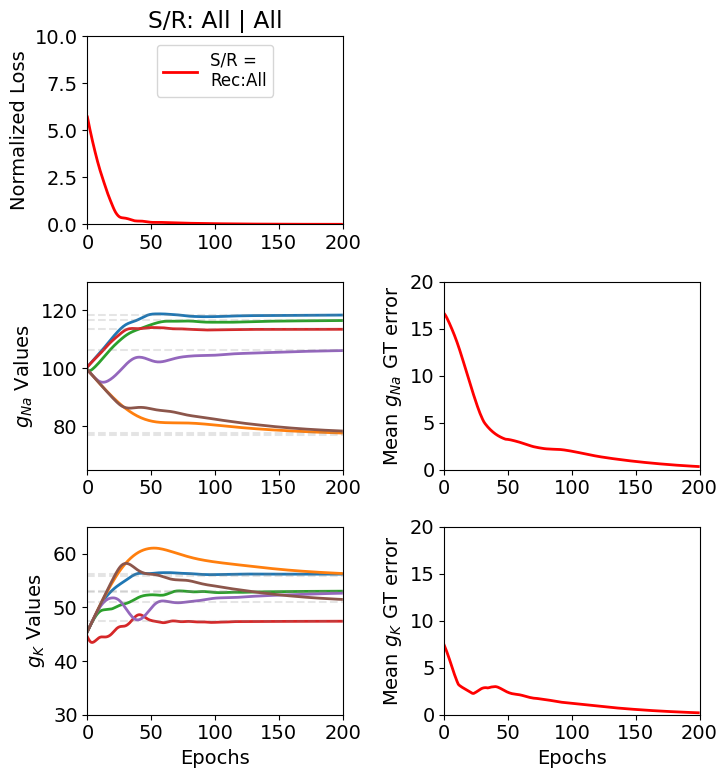

In [24]:
# Arrange condition indexes for plotting purposes
entry_ixs = fig_1_selected.index
print(entry_ixs)

# Normalize losses based on how many recording sites there are
norm_denom = 6

# Set xlim for plotting epochs
xlim_epochs = 200

# Set colors for plotting
num_colors = len(entry_ixs)
hues = np.linspace(0, 1, num_colors, endpoint=False)
rgb_colors = [mcolors.hsv_to_rgb([hue, 1.0, 1.0]) for hue in hues]
linewidth = 2
alpha = 0.8

#### Fig 2B-D ####

# Figure Plot losses and ground truth errors
fig = plt.figure(figsize=(7.5, 8))

plt.subplot(3, 2, 2)
plt.axis('off')

ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 4)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 6)
ax5 = plt.subplot(3, 2, 5)

# Plot control data condition
entry_ix = entry_ixs[0]

# Load loss and parameter trajectories over training
loss_curve = torch.load(data_lookup.loc[entry_ix]['loss_filename_id'])
g_Na_curve = torch.load(data_lookup.loc[entry_ix]['g_Na_filename_id'])
g_K_curve = torch.load(data_lookup.loc[entry_ix]['g_K_filename_id'])

# Load target parameter generation settings
center = data_lookup.loc[entry_ix]['mu']
perturb = data_lookup.loc[entry_ix]['sigma']
lin_nodes = data_lookup.loc[entry_ix]['lin_nodes']
seed = data_lookup.loc[entry_ix]['seed']

stim = data_lookup.loc[entry_ix]['stim_locations']
rec = data_lookup.loc[entry_ix]['rec_locations']
noise_sigma = data_lookup.loc[entry_ix]['noise_sigma']

if stim == None:
    stim = 'All'
if rec == None:
    rec = 'All'

# Generate target paramters
g_targets = init_random_model_params(hyperparams=hyperparams_model,
                                         center=center,
                                         perturb=perturb,
                                         manual_seed=seed,
                                        )
# Calculate distance between gt and trial params

scaling = np.array([[100],[45]]) # Original parameter values for g_Na and g_K
g_targets_scaled = g_targets * scaling
gt_curve = np.empty((2,len(g_Na_curve)))
gt_curve[0] = np.mean(np.abs(np.array((g_targets_scaled[0] - g_Na_curve))), 1)
gt_curve[1] = np.mean(np.abs(np.array((g_targets_scaled[1] - g_K_curve))), 1)
gt_curve = gt_curve.transpose()


# Plot Normalized Loss
ax1.plot(loss_curve/norm_denom, 
           linewidth=linewidth,
           label=f"S/R = \nRec:{rec}",
           color=rgb_colors[0],
          )

# Plot g_Na ground truth error trajectory
ax2.plot(gt_curve[:,0], 
       linewidth=linewidth,
       label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}",
       color=rgb_colors[0],
      )
# Plot g_K ground truth error trajectory
ax4.plot(gt_curve[:,1], 
           linewidth=linewidth,
           label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}",
           color=rgb_colors[0],
          )

# Figure 2D, left - raw and target parameter trajectories
for j in range(g_Na_curve.shape[1]):
    # Plot gNa and gK raw parameter trajectories
    ax3.plot(range(len(g_Na_curve)), 
               g_Na_curve[:,j], 
               linewidth=linewidth,
              )
    ax5.plot(range(len(g_K_curve)), 
               g_K_curve[:,j], 
               linewidth=linewidth,
              )

    # Plot gNa and gK target parameter value lines
    ax3.axhline(y=g_targets[0,j]*100, 
              color='grey', 
              linestyle='--',
              alpha = 0.2,
             )
    ax5.axhline(y=g_targets[1,j]*45, 
                  color='grey', 
                  linestyle='--', 
                  alpha = 0.2,
                 )

# Plotting settings

ax1.set_ylim(0, 10)
ax3.set_ylim(65, 130)
ax5.set_ylim(30, 65)
ax1.set_xlim(0,xlim_epochs)
ax3.set_xlim(0,xlim_epochs)
ax5.set_xlim(0,xlim_epochs)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=1, fontsize=12)



ax2.set_ylim(0,20)
ax4.set_ylim(0,20)
ax2.set_xlim(0,xlim_epochs)
ax4.set_xlim(0,xlim_epochs)


ax1.set_ylabel('Normalized Loss')
ax3.set_ylabel(r'$g_{Na}$ Values')
ax5.set_ylabel(r'$g_{K}$ Values')

# ax1.set_xlabel('Epochs')
ax4.set_xlabel('Epochs')
ax5.set_xlabel('Epochs')


ax2.set_ylabel(r'Mean $g_{Na}$ GT error')
ax4.set_ylabel(r'Mean $g_{K}$ GT error')

ax1.set_title(f'S/R: {stim} | {rec}')


fig.tight_layout()


fig_1_1_filename = 'Fig1_1.svg'

plt.savefig(PATH_images+fig_1_1_filename, format='svg')

plt.show()

### Figure 2C

Last index where the difference is less than 0.01: 74
Last index where the difference is less than 0.005: 104
Last index where the difference is less than 0.001: 163


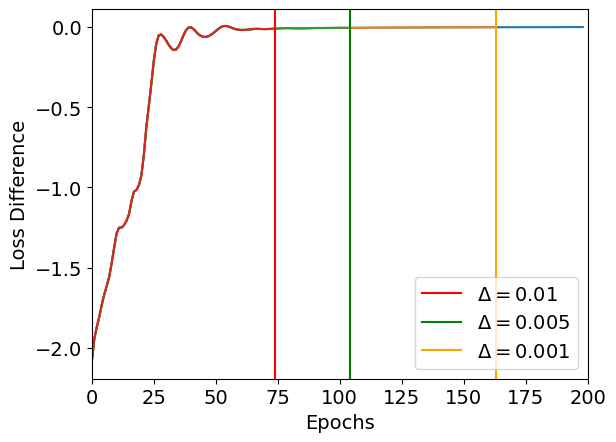

In [25]:
# Plot potential early stopping points

# Convert loss_curve to numpy arrauy
a = np.array(loss_curve)

# Find the index where the difference is less than threshold
index = np.where(np.abs(np.diff(np.array(loss_curve))) > 0.01)[0][-1]
index_2 = np.where(np.abs(np.diff(np.array(loss_curve))) > 0.005)[0][-1]
index_3 = np.where(np.abs(np.diff(np.array(loss_curve))) > 0.001)[0][-1]

print("Last index where the difference is less than 0.01:", index)
print("Last index where the difference is less than 0.005:", index_2)
print("Last index where the difference is less than 0.001:", index_3)

plt.plot(np.diff(a))
plt.plot(np.arange(index_3), np.diff(a)[:index_3])
plt.plot(np.arange(index_2), np.diff(a)[:index_2])
plt.plot(np.arange(index), np.diff(a)[:index])

plt.axvline(index, color='red', label=r'$\Delta=0.01$')
plt.axvline(index_2, color='green', label=r'$\Delta=0.005$')
plt.axvline(index_3, color='orange', label=r'$\Delta=0.001$')

plt.xlabel('Epochs')
plt.ylabel('Loss Difference')
plt.xlim(0,200)

plt.legend()

fig_sup_1_filename = 'fig_sup_1.svg'
plt.savefig(PATH_images+fig_sup_1_filename, format='svg')

plt.show()


## Recreate Figure 2 to include 2C

Last index where the difference is less than 0.01: 74
Last index where the difference is less than 0.005: 104
Last index where the difference is less than 0.001: 163


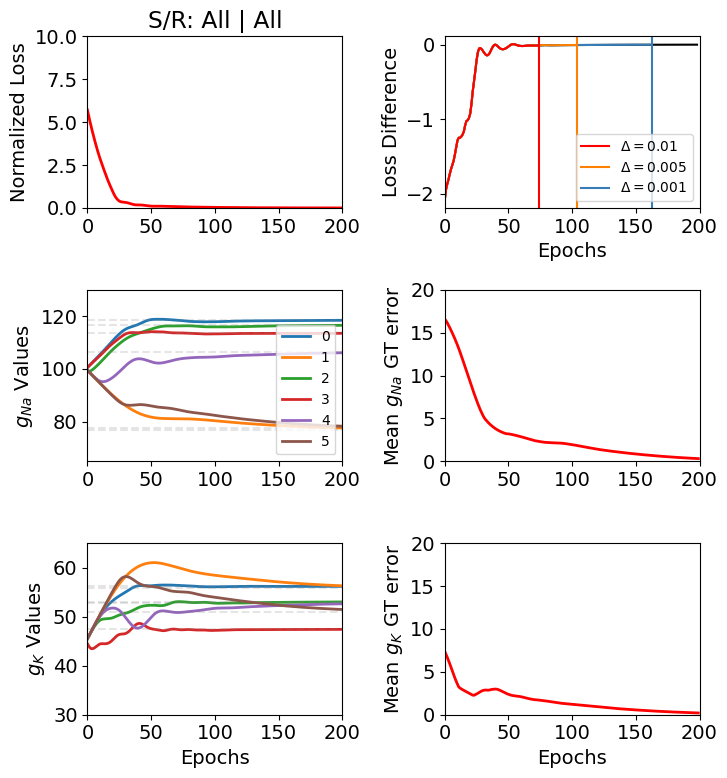

In [26]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Example entry index list
entry_ixs = fig_1_selected.index

norm_denom = 6

# Parameters
xlim_epochs = 200
linewidth = 2
alpha = 0.8

# Generate colors for plotting
num_colors = len(entry_ixs)
hues = np.linspace(0, 1, num_colors, endpoint=False)
rgb_colors = [mcolors.hsv_to_rgb([hue, 1.0, 1.0]) for hue in hues]

# Initialize figure
fig = plt.figure(figsize=(7.5, 8))

# Create subplots
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 4)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 6)
ax5 = plt.subplot(3, 2, 5)
ax6 = plt.subplot(3, 2, 2)

# Get data
entry_ix = entry_ixs[0]
loss_curve = torch.load(data_lookup.loc[entry_ix]['loss_filename_id'])
g_Na_curve = torch.load(data_lookup.loc[entry_ix]['g_Na_filename_id'])
g_K_curve = torch.load(data_lookup.loc[entry_ix]['g_K_filename_id'])
center = data_lookup.loc[entry_ix]['mu']
perturb = data_lookup.loc[entry_ix]['sigma']
lin_nodes = data_lookup.loc[entry_ix]['lin_nodes']
seed = data_lookup.loc[entry_ix]['seed']
stim = data_lookup.loc[entry_ix]['stim_locations']
rec = data_lookup.loc[entry_ix]['rec_locations']
noise_sigma = data_lookup.loc[entry_ix]['noise_sigma']

if stim is None:
    stim = 'All'
if rec is None:
    rec = 'All'

g_targets = init_random_model_params(hyperparams=hyperparams_model, center=center, perturb=perturb, manual_seed=seed)
scaling = np.array([[100], [45]])
g_targets_scaled = g_targets * scaling
gt_curve = np.empty((2, len(g_Na_curve)))
gt_curve[0] = np.mean(np.abs(np.array((g_targets_scaled[0] - g_Na_curve))), 1)
gt_curve[1] = np.mean(np.abs(np.array((g_targets_scaled[1] - g_K_curve))), 1)
gt_curve = gt_curve.transpose()

# Plotting
ax1.plot(loss_curve/norm_denom, linewidth=linewidth, label=f"S/R = \nRec:{rec}", color=rgb_colors[0])
ax2.plot(gt_curve[:, 0], linewidth=linewidth, label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}", color=rgb_colors[0])
ax4.plot(gt_curve[:, 1], linewidth=linewidth, label=f"ix:{entry_ix} | stim: {stim} | rec: {rec}", color=rgb_colors[0])

for j in range(g_Na_curve.shape[1]):
    ax3.plot(range(len(g_Na_curve)), g_Na_curve[:, j], linewidth=linewidth, label=j)
    ax5.plot(range(len(g_K_curve)), g_K_curve[:, j], linewidth=linewidth)
    ax3.axhline(y=g_targets[0, j] * 100, color='grey', linestyle='--', alpha=0.2)
    ax5.axhline(y=g_targets[1, j] * 45, color='grey', linestyle='--', alpha=0.2)

# Add 2C
a = np.array(loss_curve)
index = np.where(np.abs(np.diff(np.array(loss_curve))) > 0.01)[0][-1]
index_2 = np.where(np.abs(np.diff(np.array(loss_curve))) > 0.005)[0][-1]
index_3 = np.where(np.abs(np.diff(np.array(loss_curve))) > 0.001)[0][-1]

print("Last index where the difference is less than 0.01:", index)
print("Last index where the difference is less than 0.005:", index_2)
print("Last index where the difference is less than 0.001:", index_3)

ax6.plot(np.diff(a), color='black')
ax6.plot(np.arange(index_3), np.diff(a)[:index_3], color='#377eb8')
ax6.plot(np.arange(index_2), np.diff(a)[:index_2], color='#ff7f00')
ax6.plot(np.arange(index), np.diff(a)[:index], color='#FF0000')
ax6.axvline(index, color='#FF0000', label=r'$\Delta=0.01$')
ax6.axvline(index_2, color='#ff7f00', label=r'$\Delta=0.005$')
ax6.axvline(index_3, color='#377eb8', label=r'$\Delta=0.001$')

# Set labels and limits for ax6
ax6.set_xlabel('Epochs')
ax6.set_ylabel('Loss Difference')
ax6.set_xlim(0, 200)
ax6.legend(fontsize=10)

# Set y-limits for the other axes
ax1.set_ylim(0, 10)
ax3.set_ylim(65, 130)
ax5.set_ylim(30, 65)
ax1.set_xlim(0, xlim_epochs)
ax3.set_xlim(0, xlim_epochs)
ax5.set_xlim(0, xlim_epochs)
ax3.legend(fontsize=10)

ax2.set_ylim(0, 20)
ax4.set_ylim(0, 20)
ax2.set_xlim(0, xlim_epochs)
ax4.set_xlim(0, xlim_epochs)

ax1.set_ylabel('Normalized Loss')
ax3.set_ylabel(r'$g_{Na}$ Values')
ax5.set_ylabel(r'$g_{K}$ Values')
ax4.set_xlabel('Epochs')
ax5.set_xlabel('Epochs')
ax2.set_ylabel(r'Mean $g_{Na}$ GT error')
ax4.set_ylabel(r'Mean $g_{K}$ GT error')
ax1.set_title(f'S/R: {stim} | {rec}')

fig.tight_layout()


fig_1_1a_filename = 'Fig1_1a.svg'
plt.savefig(PATH_images + fig_1_1a_filename, format='svg')
plt.show()